# Réseaux neuronaux convolutifs

Au dernier cours, nous avons vu comment construire un réseau neuronal simple et pleinement connecté ainsi que comment l'appliquer à la classification d'images.
Nous avons aussi couvert comment entraîner ce réseau et l'appliquer à des données test, ou encore à des données provenant de sources externes.

Or, le réseau pleinement connecté que nous utilisions n'était pas nécessairement le plus adapté  à la classification d'images. Pour ce genre de tâche un réseau neuronal convolutif est généralement plus approprié.
Nous verrons aujourd'hui comment implémenter un tel réseau avec PyTorch.

## Données

Nous allons commencer par appliquer notre modèle aux mêmes données qu'au dernier cours, soit l'ensemble FashionMNIST.

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

device = "cuda" if torch.cuda.is_available() else "cpu"

training_data = datasets.FashionMNIST(
    root="../cours03-images-mlp-pytorch/data",  # On réutilise le même dossier pour ne pas télécharger en double
    train=True,
    download=True,
    transform=ToTensor(),  # Transformation de tableau PIL vers tenseur
)
test_data = datasets.FashionMNIST(
    root="../cours03-images-mlp-pytorch/data",
    train=False,
    download=True,
    transform=ToTensor(),
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
inv_labels_map = dict(zip(labels_map.values(), labels_map.keys()))

In [2]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

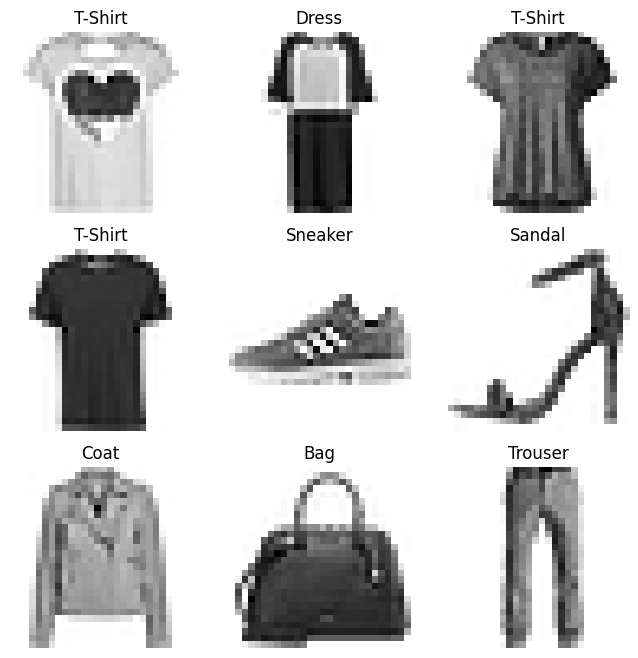

In [3]:
import matplotlib.pyplot as plt

def plot_grid(data):
    """
    Fonction pour tirer 9 images au hasard d'un Dataset PyTorch et les fafficher
    """
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        # On tire une image au hasard et on l'affiche
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0), cmap="binary")
    return figure
    
plot_grid(training_data)
plt.show()

## Définition d'un CNN

### Couche de convolution

Commençons par nous familiariser avec la couche de convolution 2D de PyTorch, soit [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

**Exercices:**

1. Le premier paramètre de `Conv2d` est le nombre de canaux en entrée. Combien de canaux d'entrée une couche de convolution utilisée sur les données Fashion MNST?
2. Créez un modèle simple en assignant directement `model` à une couche de convolution, par exemple `model = nn.Conv2d(*args)` où `*args` est remplacé par les arguments requis. La couche de convolution devrait avoir le nombre de canaux d'entrée adéquat pour les données Fahsion MNIST et 8 canaux de sortie. Utilisez un noyaux de 5 pixels pour la convolution.
3. Affichez les paramètres de ce modèle. Quel est le format (`shape`) des poids ?
4. Passez une des images d'entraînement dans le modèle. Quelles sont les dimensions de sortie?

In [4]:
from torch import nn

model = nn.Conv2d(1, 8, 5)

In [5]:
named_parameters = list(model.named_parameters())
print(named_parameters)

[('weight', Parameter containing:
tensor([[[[ 0.0733,  0.0363, -0.1189, -0.1657, -0.1086],
          [-0.0007,  0.0017, -0.0503, -0.0089, -0.1799],
          [ 0.1095,  0.1438,  0.0530, -0.0736,  0.1767],
          [ 0.1471,  0.0344,  0.1652, -0.1257, -0.1462],
          [ 0.0890, -0.1768, -0.0343, -0.0822,  0.1284]]],


        [[[ 0.0952, -0.1241, -0.0222, -0.1554,  0.0615],
          [-0.0045, -0.0671, -0.0230, -0.0947, -0.0946],
          [ 0.1739, -0.1150,  0.1458, -0.0416, -0.1708],
          [-0.0069,  0.0594, -0.1532, -0.1758, -0.1732],
          [-0.1717, -0.1649, -0.0851, -0.1459,  0.1836]]],


        [[[ 0.0935,  0.1856,  0.0911, -0.0853,  0.0918],
          [ 0.1697, -0.1907,  0.1195, -0.1242, -0.1581],
          [ 0.1291, -0.0560,  0.2000, -0.1311, -0.0321],
          [-0.0898,  0.1851,  0.1744, -0.0916, -0.1312],
          [-0.1107,  0.0933, -0.1413, -0.1753, -0.0486]]],


        [[[ 0.0552, -0.0071,  0.1511,  0.1366, -0.0694],
          [-0.0642, -0.1358, -0.0810, -0.0

In [6]:
print("Format des poids", named_parameters[0][1].shape)

Format des poids torch.Size([8, 1, 5, 5])


In [7]:
img = training_data[514][0]
print("Format de l'image", img.shape)
out = model(img)
print("Format de la sortie", out.shape)

Format de l'image torch.Size([1, 28, 28])
Format de la sortie torch.Size([8, 24, 24])


### Calcul des dimensions de sortie

Pour une seule couche de convolution, il est facile de vérifier les dimensions de sortie. Pour se faciliter la vie, on peut également définir une fonction qui fait ce calcul. Pour un padding de type `same`, c'est assez facile: les dimensions de sortie sont égales à celles d'entrée. Or, pour un padding `valid`, ce ne sera pas le cas. De manière générale, les dimensions de sortie d'une convolution sont données par l'équation ci-dessous.

Pour une image de hauteur (et largeur) $H_in$, la hauteur (et largeur) de la couche de sortie est donnée par:

$$
H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding} - \text{dilation}
                        \times (\text{kernel\_size} - 1) - 1}{\text{stride}} + 1\right\rfloor
$$

Pour nous, dans la plupart des cas:
- `padding=0` car on utilise une convolution "valid" par défaut
- `stride=1` car on glisse le noyau de convolution pixel par pixel
- `dilation=1`: on ne dilate pas le noyau

On peut voir intuitivement que:

- Un plus padding plus grand augmente la dimension de sortie
- Un `stride` (un pas) plus grand diminue les dimensions (on répète la convolution à moinds d'emplacements sur l'image)
- Un noyau plus grand résulte en une dimension de sortie plus petite: plus les pixels du noyau couvrent une grande partie de l'image, moins on a de jeu pour glisser la convolution. C'est un peu la même idée avec la dilatation.

**Exercice: Implémentez une fonction qui calcule cette équation et vérifiez son résultat avec la convolution ci-dessus.**

In [8]:
def get_output_width(input_width, kernel_size, stride=1, padding=0, dilation=1):
    """
    - input_wdith: taille de l'entrée
    - kernel_size: taille du noyau
    - stride: pas effectué par le noyau convolution
    - padding: nombre de pixels de padding (0 pour valid, varie pour same)
    - dilation: Espacement entre les pixels du noyau
    # Ref: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
    **Attention: stride=kernel_size pour max pooling par défaut**
    """

    return int(
        (input_width + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1
    )

### Padding différent

**Exercice: Utilisez un modèle alternatif avec un padding 'same'. Le format de la couche de sortie est-il de la manière attendue?**

In [9]:
model = nn.Conv2d(1, 8, 5, padding="same")

In [10]:
img = training_data[514][0]
print("Format de l'image", img.shape)
out = model(img)
print("Format de la sortie", out.shape)

Format de l'image torch.Size([1, 28, 28])
Format de la sortie torch.Size([8, 28, 28])


### Mise en commun (_pooling_)

PyTorch implémente aussi des couches de mise en commun: [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html).

**Exercice: Implémentez une couche de mise en commun de dimension 5 et utilisez-la sur une image d'entraînement. Quelles sont les dimensions de sortie? Comment diffèrent-elles d'une convolution? Est-ce cohérent avec l'équation vue plus haut? Affichez sur deux graphiques côte à côte l'image initiale et le résultat du pooling.**

<details>
    <summary>Explication concernant la taille de sortie</summary>
    Par défaut, pour `MaxPool2d`, `stride=kernel_size`.
</details>

In [11]:
pool = nn.MaxPool2d(5)

In [12]:
print("Format de l'image", img.shape)
out = pool(img)
print("Format de la sortie", out.shape)

Format de l'image torch.Size([1, 28, 28])
Format de la sortie torch.Size([1, 5, 5])


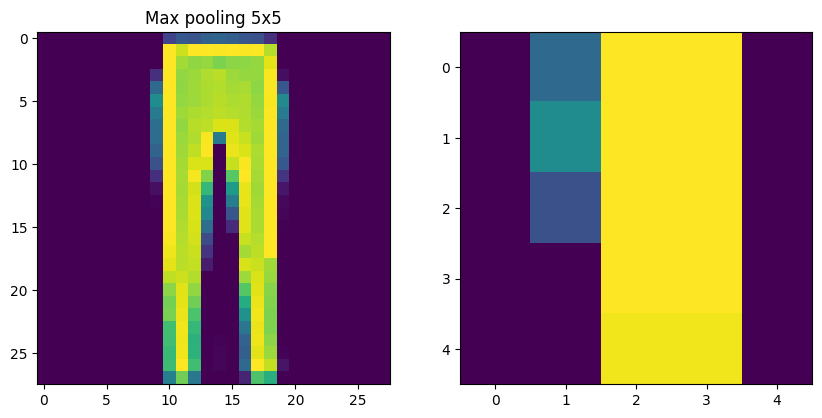

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img.squeeze())
axs[0].set_title("Image")
axs[1].imshow(out.squeeze())
axs[0].set_title("Max pooling 5x5")
plt.show()

### Définition d'un CNN complet

Pour définir un CNN, il suffit de combiner une ou plusieurs couches de convolution comme celle définie ci-dessus dans un réseau neuronal.

**Exercice: Définissez un CNN avec les caractéristiques ci-dessous. Essayez d'abord de le faire sans retourner voir l'exemple du dernier cours, mais n'hésitez pas à vous y référer au besoin.**

- Une première couche de convolution avec 6 canaux de sortie et un noyaux de largeur 5
- Une deuxième couche de convolution avec 16 canaux de sortie et un noyaux de largeur 5
- Trois couches pleinement connectées avec 120, 84 et 10 neurones
- Une fonction d'activation ReLU pour toutes les couches sauf la dernière
- Un pooling "max" 2x2 après l'activation des couches de convolution.
- Dans l'exemple du dernier cours, nous avons utilisé `nn.Flatten` pour applatir les images. Nous en aurons besoin ici également. À quel endroit dans le réseau doit on applatir les données?

In [14]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Pooling 2x2, assigné à pool car on le réutilise plusieurs fois
        self.pool = nn.MaxPool2d(2)
        self.activation = nn.ReLU()

        # Séquence de convolutions
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            self.activation,
            self.pool,
            nn.Conv2d(6, 16, 5),
            self.activation,
            self.pool,
        )

        # Opérations pour convertir les images 2d en 1d
        self.flatten = nn.Flatten()
        
        # stride=kernel_size pour maxpool par défaut
        self.linear_entry_dim = get_output_width(get_output_width(
            get_output_width(get_output_width(28, 5), 2, stride=2), 5
        ), 2, stride=2)

        # Séquence de couches pleinement connectées
        self.linear_stack = nn.Sequential(
            nn.Linear(16 * self.linear_entry_dim**2, 120),
            self.activation,
            nn.Linear(120, 84),
            self.activation,
            nn.Linear(84, 10),
        )

    def forward(self, x):
        # La séquence de convolution d'abbord
        x = self.conv_stack(x)
        # On applatit l'image
        x = self.flatten(x)
        # La séquence pleinement connectée
        logits = self.linear_stack(x)
        return logits

**Exercice: créez une instance de votre modèle. Quelle est la dimension d'entrée de la première couche pleinement connectée?**

In [15]:
model = ConvNet().to(device)

In [16]:
model.linear_entry_dim

4

### Test rapide du modèle

**Exercice: Assurez-vous que votre modèle fonctionne sur une image tirée de `training_data` et un sous-ensemble tiré de `train_dataloader`.**
Pour l'image seule, n'oubliez pas d'ajouter la dimension de "batch" avec `img.unsqueeze()`.

In [17]:
model(img.unsqueeze(0))

tensor([[ 0.0903,  0.1526,  0.0554, -0.1078, -0.0697, -0.0517, -0.0504,  0.0732,
         -0.0129, -0.0655]], grad_fn=<AddmmBackward0>)

In [18]:
model(next(iter(train_dataloader))[0]).shape

torch.Size([64, 10])

## Entraînement

**Exercie: Entraînez le réseau avec une fonction objectif _cross-entropy_.**

Essayez de vous référer à l'exemple du dernier cours le moins possible, mais consultez le au besoin.

Rappel des étapes:

- Définition de la fonction objectif et de l'optimiseur
- Définition d'une boucle d'entraînement et d'une boucle de test
- Itération sur les époques (commencez par 10)

In [19]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

In [20]:
loss_fn = nn.CrossEntropyLoss()

In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
def train_loop(dataloader, model, loss_fn, optimizer):

    # Taille de l'ensemble d'entraînement
    size = len(dataloader.dataset)

    # Itération sur les batches (dataloader nous donne les données par batch)
    # X est l'image et y la classe
    train_loss = 0.0
    for batch, (X, y) in enumerate(dataloader):
        # Fonction objectif
        pred = model(X)  # prédiction
        loss = loss_fn(pred, y)

        # Rétropropagation
        optimizer.zero_grad()  # On réinitialise le gradient d'abord
        loss.backward()  # Rétropropagation
        optimizer.step()  # On fait un pas dans l'espace paramètre

        loss, current = loss.item(), batch * len(X)
        train_loss += loss * X.size(0)
        # Progrès
        if batch % 100 == 0:
            print(f"Loss: {loss}, [{current}/{size}]")

    return train_loss / size

In [23]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = correct = 0

    # On se sauve les gradients comme ils ne sont pas utilisés
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()  # Compute loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct)}%, Avg loss: {test_loss} \n")

    return test_loss

In [24]:
epochs = 10
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
Loss: 2.288346767425537, [0/60000]
Loss: 2.2991647720336914, [6400/60000]
Loss: 2.3030712604522705, [12800/60000]
Loss: 2.3025474548339844, [19200/60000]
Loss: 2.2969048023223877, [25600/60000]
Loss: 2.289412498474121, [32000/60000]
Loss: 2.297769784927368, [38400/60000]
Loss: 2.3037221431732178, [44800/60000]
Loss: 2.279118776321411, [51200/60000]
Loss: 2.2863616943359375, [57600/60000]
Test Error: 
 Accuracy: 14.899999999999999%, Avg loss: 2.2888423713149537 

Epoch 2
-------------------------------
Loss: 2.295375108718872, [0/60000]
Loss: 2.2946531772613525, [6400/60000]
Loss: 2.293431282043457, [12800/60000]
Loss: 2.2742855548858643, [19200/60000]
Loss: 2.294527530670166, [25600/60000]
Loss: 2.274301290512085, [32000/60000]
Loss: 2.282196283340454, [38400/60000]
Loss: 2.27060866355896, [44800/60000]
Loss: 2.2955362796783447, [51200/60000]
Loss: 2.276710271835327, [57600/60000]
Test Error: 
 Accuracy: 19.33%, Avg loss: 2.267539335663911 

Epoc

**Exercice: Affichez l'évolution de la fonciton objectif pour les données d'entraînement et de test.**


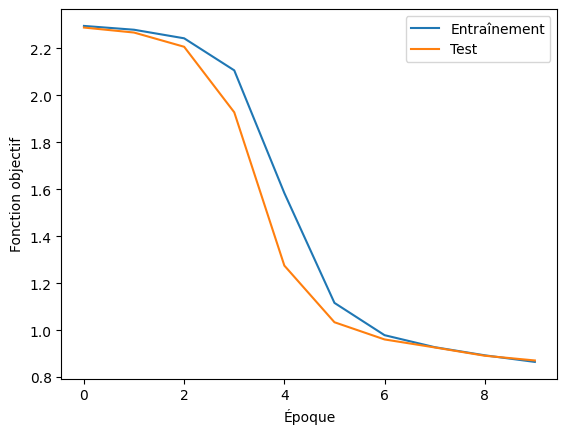

In [25]:
plt.plot(train_losses, label="Entraînement")
plt.plot(test_losses, label="Test")
plt.xlabel("Époque")
plt.ylabel("Fonction objectif")
plt.legend()
plt.show()

Remarquez que la performance après 10 époques est moins bonne que pour le réseau pleinement connecté du dernier cours! Ceci s'explique en partie le fait que notre réseau est très simple et en partie par le fait que nous avons coupé l'entraînement relativement tôt.

**NOTE:** Avec l'optimiseur SGD et le nombre d'époques qaue l'on utilise, il se peut que l'entraînement n'ait pas bien fonctionné. Si vous êtes à moins de 50% de précision vous pouvez ajouter quelques époques et recommencer l'entraînement (ou continuer d'où il s'est arrêté).

## Inspection du modèle

Comme au dernier cours, on pourrait utiliser le modèle entraîner pour prédire différents exemples. Le code serait pratiquement le même.

Par contre, comme nous avons un CNN ici, on peut essayer d'interpréter les poids dans les différentes convolutions.

**Exercice: Accédez à la première couche de convolution. Ensuite, accédez à ses poids et affichez le poids pour les différents canaux.**

<details>
    <summary>Indice</summary>
    Il faudra d'abord accéder à `conv_stack` et `conv_stack` est comme une liste, donc on peut l'indexer.
</details>

In [26]:
conv1 = model.conv_stack[0]

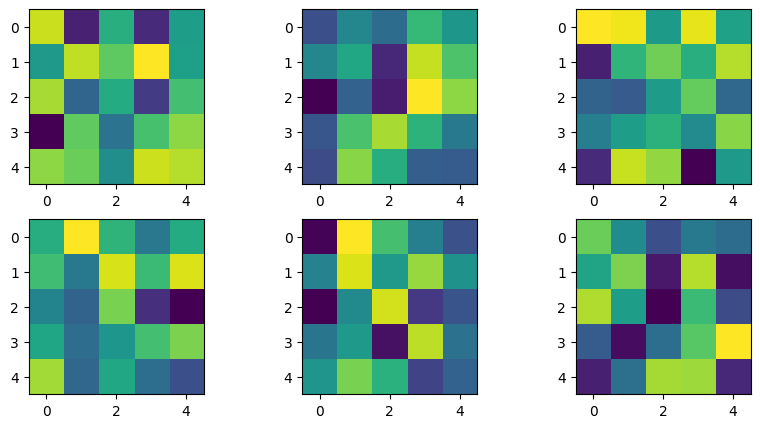

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].imshow(conv1.weight[i].squeeze().detach())

Assez difficile d'interpréter quoi que ce soit ici!

**Exercice: Affichez maintenant les sorties de la première couche pour une image tirée au hasard des données d'entraînement**.

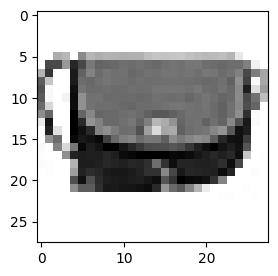

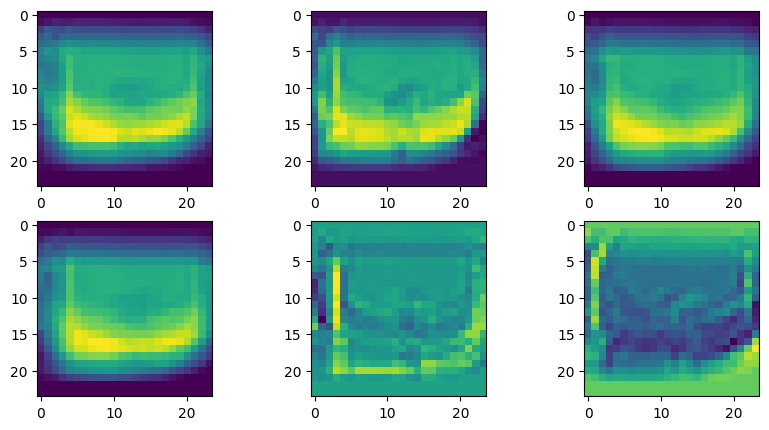

In [28]:
import random

img = training_data[random.randint(0, len(training_data))][0]
out1 = conv1(img.unsqueeze(0)).squeeze()

plt.figure(figsize=(3,3))
plt.imshow(img.squeeze(), cmap="binary")
plt.show()

fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].imshow(out1[i].detach())

## Exercices additionnels

- Modifiez le réseau ci-dessus en ajoutant des canaux, des couches et/ou en modifiant la taille des noyaux de convolutions et explorez l'effet sur le résultat.
- Modifiez le réseau ci-dessus afin qu'il accepte des images RGB avec 3 canaux et testez le sur les données CIFAR-10 (` torchvision.datasets.CIFAR10`)
- Utilisez un "dropout" dans le modèle
- Utilisez une "Batch normalization"